In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv1D, Conv2D, Dense, Input, Concatenate, Reshape, Lambda
from keras.utils import plot_model
from scipy import stats as ss
from scipy import optimize
from scipy.interpolate import griddata
from IPython.display import Image, display

Using TensorFlow backend.


In [2]:
def create_model_1d(n_samples, out_dense_1, out_dense_2, depth, kernel_size, n_kernels):        
    # Number of neurons for the dense layers.
    n_channels = int(np.ceil((n_samples + kernel_size) / out_dense_2))
    
    # Shape of the output of the dense layers.
    out_dense_total = n_channels * out_dense_2
    
    # Adjusts the kernel size to fit with the previously calculated parameters.
    kernel_size = out_dense_total - n_samples + 1

    print("out_dense_1:", out_dense_1, "\nout_dense_2:", out_dense_2, "\nn_channels:",
          n_channels, "\nout_dense_total:", out_dense_total, "\nkernel_size:", kernel_size,
          "\nn_kernels:", n_kernels)
    
    # Model input.
    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)

    # Create the first two (dense) layers.
    layer_1 = []
    layer_2 = []
    reshape = []
    
    for i in range(n_channels):
        layer_1.append(Dense(out_dense_1 * depth, activation='relu', name='layer_1_{:02d}'.format(i))(model))
        layer_2.append(Dense(out_dense_2 * depth, activation='relu', name='layer_2_{:02d}'.format(i))(layer_1[-1]))
        reshape.append(Reshape(target_shape=(out_dense_2, depth))(layer_2[-1]))
    
    concat = Concatenate(axis=-1)(reshape)
    print("Shape after concat:", concat.shape)

    reshape = Reshape(target_shape=(out_dense_total, depth))(concat)
    print("Shape after reshape:", reshape.shape)
    
    conv = Conv1D(filters=n_kernels, kernel_size=kernel_size, strides=1)(reshape)
    
    avg = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    model = keras.Model(model, avg)
    
    plot_model(model, show_shapes=True, to_file='model.png')
    display(Image(retina=True, filename='model.png'))
    
    return model

In [7]:
def create_model_2d(n_samples, out_dense_1, out_dense_2, depth, kernel_size, n_kernels):      
    # Number of neurons for the dense layers.
    n_channels = int(np.ceil((n_samples + kernel_size) / out_dense_2))
    
    # Shape of the output of the dense layers.
    out_dense_total = n_channels * out_dense_2
    
    # Adjusts the kernel size to fit with the previously calculated parameters.
    kernel_size = out_dense_total - n_samples + 1

    print("out_dense_1:", out_dense_1, "\nout_dense_2:", out_dense_2, "\nn_channels:",
          n_channels, "\nout_dense_total:", out_dense_total, "\nkernel_size:", kernel_size,
          "\nn_kernels:", n_kernels)
    
    # Model input.
    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)

    # Create the first two (dense) layers.
    layer_1 = []
    layer_2 = []
    reshape = []
    
    for i in range(n_channels):
        layer_1.append(Dense(out_dense_1 * depth, activation='relu', name='layer_1_{:02d}'.format(i))(model))
        layer_2.append(Dense(out_dense_2 * depth, activation='relu', name='layer_2_{:02d}'.format(i))(layer_1[-1]))
        reshape.append(Reshape(target_shape=(out_dense_2, depth, 1))(layer_2[-1]))
    
    concat = Concatenate(axis=-1)(reshape)
    print("Shape after concat:", concat.shape)

    reshape = Reshape(target_shape=(out_dense_total, depth, 1))(concat)
    print("Shape after reshape:", reshape.shape)
    
    conv = Conv2D(filters=n_kernels, kernel_size=(kernel_size, depth), strides=1)(reshape)
    
    avg = Lambda(lambda x: K.sum(x, axis=-1), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    reshape_after_avg = Reshape(target_shape=(n_samples,))(avg)
    print("Shape after reshape:", reshape.shape)    
    
    model = keras.Model(model, reshape_after_avg)
    
    plot_model(model, show_shapes=True, to_file='model.png')
    display(Image(retina=True, filename='model.png'))
    
    return model

In [8]:
def gen_data(n_data, n_samples):
    mu = ss.uniform(MIN_MU, MAX_MU - MIN_MU).rvs(n_data)
    sd = ss.uniform(MIN_SD, MAX_SD - MIN_SD).rvs(n_data)
    x = np.linspace(MIN_X, MAX_X, n_samples)
    # TODO: Loss function plotting; allow for different loss functions.
    # Make sure that distributions don't get off the grid (truncated)

    params = np.concatenate((mu[..., np.newaxis], sd[..., np.newaxis]), 1)
    x_sampled = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).logpdf(x[np.newaxis, :])
    
    return params, x_sampled

In [9]:
# Define parameter range.
MIN_X, MAX_X = -10, 10
MIN_MU, MAX_MU = -3, 3
MIN_SD, MAX_SD = 0.5, 3

# Data settings.
N_DATA = 100000
N_SAMPLES = 150 # TODO Rename to grid_size

# NN Settings.
OUT_D_1 = 10
OUT_D_2 = 40
DEPTH = 25
K_SIZE = 20 # TODO Consider adding this as a fraction of the grid size
N_K = 15

out_dense_1: 10 
out_dense_2: 40 
n_channels: 5 
out_dense_total: 200 
kernel_size: 51 
n_kernels: 15
Shape after input: (?, 2)
Shape after concat: (?, 40, 25, 5)
Shape after reshape: (?, 200, 25, 1)
Shape after avg: (?, 150, 1)
Shape after reshape: (?, 200, 25, 1)


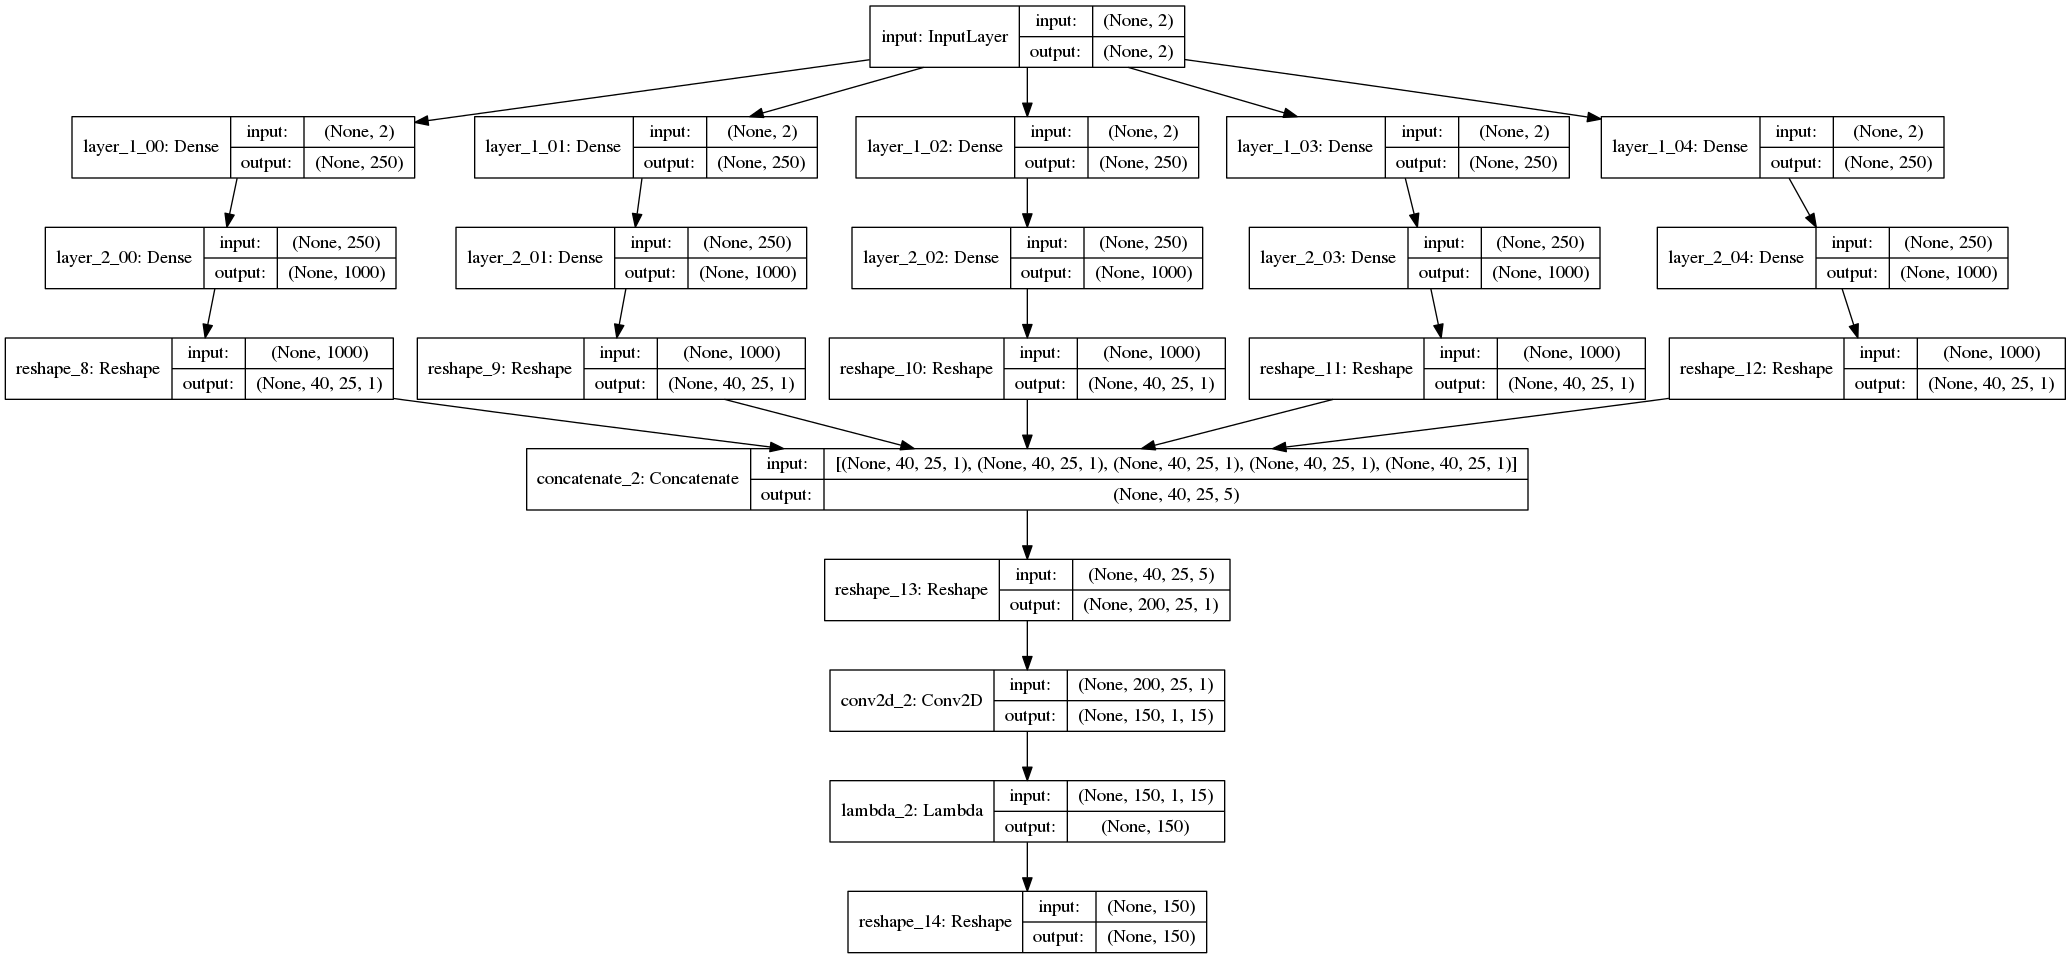

Epoch 1/5
100000/100000 [==============================] - 170s 2ms/step - loss: 12.7835
Epoch 2/5
100000/100000 [==============================] - 164s 2ms/step - loss: 0.4038
Epoch 3/5
100000/100000 [==============================] - 167s 2ms/step - loss: 0.5512
Epoch 4/5
100000/100000 [==============================] - 170s 2ms/step - loss: 0.2326
Epoch 5/5
100000/100000 [==============================] - 164s 2ms/step - loss: 0.2317


In [10]:
model = create_model_2d(N_SAMPLES, OUT_D_1, OUT_D_2, DEPTH, K_SIZE, N_K)
model.compile(optimizer='adam', loss='mean_squared_error')

params, x_sampled = gen_data(N_DATA, N_SAMPLES)
model.fit(params, x_sampled, shuffle=True, batch_size=32, epochs=5)

In [12]:
predictions = model.predict(params)

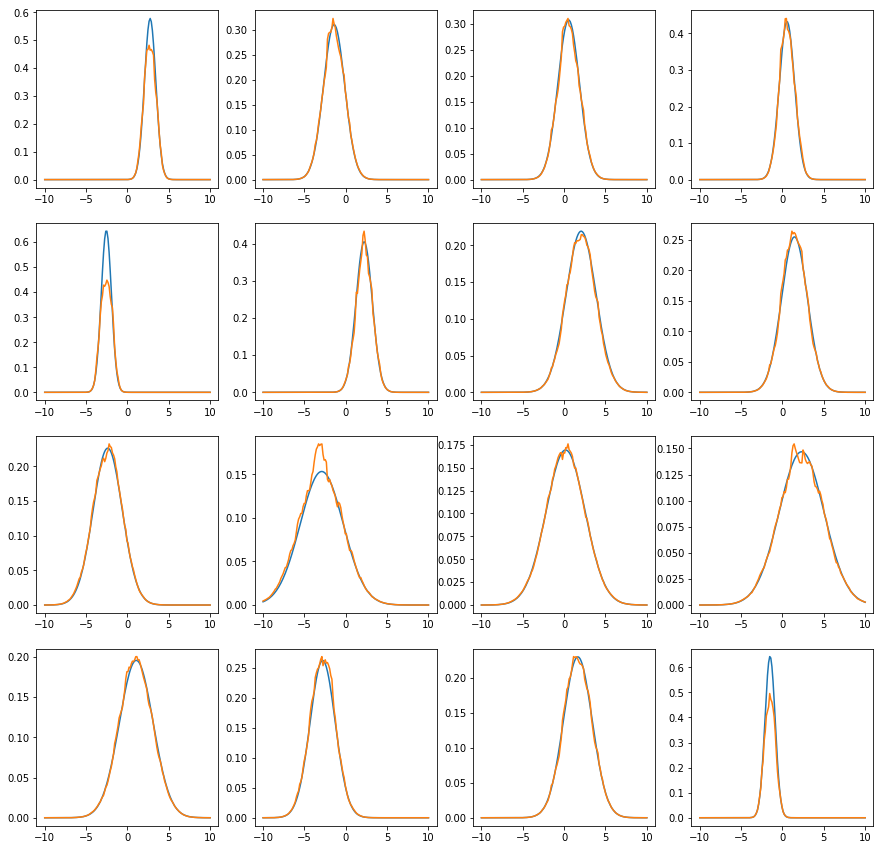

In [13]:
plt.figure(figsize=(15, 15))

for i, ix in enumerate(np.linspace(0, len(predictions), 16, dtype=int, endpoint=False)):
    plt.subplot(4, 4, i + 1)
    
    plt.plot(np.linspace(MIN_X, MAX_X, N_SAMPLES), np.exp(x_sampled[ix, :]))
    plt.plot(np.linspace(MIN_X, MAX_X, N_SAMPLES), np.exp(predictions[ix, :]))

In [14]:
# Log likelihood function.
def log_likelihood(model, theta, x_grid, x):
    if np.abs(theta[0]) > 3 or theta[1] < 0.5 or theta[1] > 3:
        return -1e9
    
    theta = np.atleast_2d(theta)
    likelihood_on_grid = model.predict(theta).T
    
    points = np.atleast_2d(x_grid).T

    ll = griddata(x_grid, likelihood_on_grid, x, fill_value=-1e9)
    
    return ll

In [116]:
def get_summed_ll(model, theta, x_grid, x):
    return np.sum(log_likelihood(model, theta, x_grid, x))

In [117]:
def estimate_mu(model, x_grid, x):
    return optimize.minimize(lambda theta: -get_summed_ll(model, theta, x_grid, x), 
                             x0=[0, 1], 
                             method='Nelder-Mead').x[0:2]

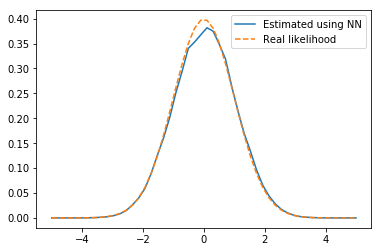

In [118]:
p = np.array([0, 1]) # Mean 0, SD 1.
pts = np.linspace(MIN_X, MAX_X, N_SAMPLES)
x_test = np.linspace(-5, 5)
ll = log_likelihood(model, p, pts, x_test)
    
plt.plot(x_test, np.exp(ll), label='Estimated using NN')
plt.plot(x_test, ss.norm().pdf(x_test), ls='--', label='Real likelihood')
plt.legend()

In [119]:
x_grid = np.linspace(MIN_X, MAX_X, N_SAMPLES)
x = ss.norm(2).rvs(300)

In [120]:
est = estimate_mu(model, x_grid, x)
print('Mu:', est[0], 'Sigma:', est[1])

Mu: 2.2117294653477444 Sigma: 1.1131762042123374


In [121]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from itertools import product

In [122]:
df = []

n_ns = 10
n_mus = 10
n_runs = 5

pars = product(np.linspace(5, 100, n_ns, dtype=int), np.linspace(-3, 3, n_mus), np.arange(n_runs))

with tqdm(total=n_ns*n_mus*n_runs) as t:
    for n, mu, trial in pars:

        test_data = ss.norm(loc=mu).rvs(n)

        nn_estimate = estimate_mu(model, x_grid, test_data)[0]
        print(nn_estimate)
        ml_estimate = np.mean(test_data)

        df.append({'n':n,
                   'mu':mu,
                   'trial':trial,
                   'nn_estimate':nn_estimate,
                   'ml_estimate':ml_estimate})
        t.update()
    
df = pd.DataFrame(df)

-2.999969856392379
-2.8733937632416144
-2.245510747435147
-2.169136387688507
-2.9999976472585144
-2.3561318223659526
-2.4353120946260454
-2.3396654981548064
-2.198342581129417
-1.4570546051272835
-1.8581550136082292
-1.021487070790262
-2.7536625923980322
-2.1946034670124392
-0.0077458555400371585
-1.1534841787732004
-1.6967964495104941
8.757400512695343e-05
-0.9747063420805966
-0.0028418387845158583
-0.7688303875517567
-0.47545912852441996
-0.7292753887308048
-0.5862375246463537
-0.5016364704182144
0.0027346569127403176
0.7593449233411638
0.0007941408157348634
0.5841537737856383
0.16902392943501454
0.3287472285888767
0.4405250926642951
1.2695851332104142
1.964323056956434
0.7332521703703634
2.1978565510791648
1.2488699362369107
2.24610947997615
0.0013278448880009828
1.82126658909122
2.607510076068471
0.0012338990867137914
2.514153660306879
0.0013278448880009828
2.230219983389202
0.0012375286436144967
0.0014538784456226514
0.0007263458370580351
2.9999628757081
2.999964985997657
-2.96880

-0.9222790399184284
-0.03935422657862127
0.0065169745969178555
-0.0005344380736351014
-0.07472279510758922
-0.1767378037091433
0.32232112421278736
0.15620010676855256
0.006576564706139081
0.3223125649203672
0.21748047496265466
0.9261805123506985
1.1929428283374746
0.9249778678064267
1.0175794321997977
0.92618769178805
1.821271891131068
1.7846178868554916
1.2683280964787116
1.417557673592134
1.36123866915966
2.999989578562341
2.246090218019576
2.2460754407457015
2.2460857267055734
2.246078740853238
2.9999996406513656
2.9999692436296836
2.9999974279510546
2.9999888160625883
2.9999808546885074
-2.9698909238835065
-2.909702321101884
-2.90969893319164
-2.9688002814453265
-2.883654942293662
-2.415358304762519
-2.9096850395222353
-2.7152331027102097
-2.2455138660147718
-2.4244740934853883
-1.443158240755834
-1.4038457981081964
-1.7926620945062322
-1.6967171895077597
-1.7926778319178227
-0.972974896456288
-0.7688625059248257
-0.7702040025541712
-0.9757915386607203
-1.184869436324833
-0.0876125

In [123]:
df_ = df.melt(id_vars=['mu', 'n', 'trial'], var_name='method', value_name='estimate')

In [124]:
tmp = df_.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['mu'])[0]).to_frame('r')

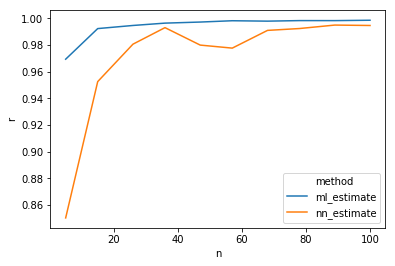

In [125]:
sns.lineplot('n', 'r', 'method', data=tmp.reset_index())